<img src='https://i.imgur.com/JZ7Hynh.jpg' style='float:left;width:100px'>

<H3>Hugging Face  / NLP - BERT</H3> 
The AI community building the future.

<a href='https://huggingface.co/'>huggingface.co</a>


Classificar a categoria de um determinado informe enviado pelos gestores de fundos imobiliários usando processamento de linguagem natural.

**Categorias escolhidas:**

* Assembléia
* Aviso aos Cotistas
* Fato Relevante
* Oferta Pública de Distribuição de Cotas
_____________

<img src='https://logospng.org/download/b3/logo-b3-brasil-bolsa-balcao-256.png' style='width:100px' />
<strong>SISTEMA FUNDOSNET</strong>
<br />
Desenvolvido pela B3, por meio de convênio firmado com a CVM e ANBIMA, o
sistema FundosNet é o canal de entrega dos documentos e informações
periódicas ou eventuais dos fundos de investimento imobiliário (“FII”) e dos
Fundos de Investimento em Índice de Mercado – Fundos de Índice,
tradicionalmente conhecidos como ETFs (“ETF”), em conjunto “Fundos”,
cumprindo, de uma só vez, a obrigação de envio simultâneo à CVM e à
entidade administradora de mercado organizado em que as cotas sejam
admitidas à negociação.

<a href='http://www.b3.com.br/data/files/6E/65/A2/16/BCAF4610BE423F46AC094EA8/W__Departamental_Intra_Diretorias_INTRA_DF-DRE_Regulacao_Manuais_Manual%20do%20Sistema%20FundosNet_Versao%20em%20Revisao_Manual%20FundosNet.pdf' target='_new'>Manual B3</a>
<hr/>
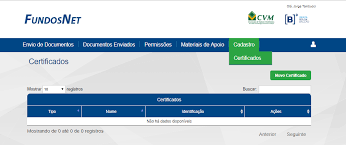

### Setup...

In [ ]:
import os
import re
import sys
import nltk
import time
import string
import warnings
import numpy as np 
import pandas as pd 
#!pip install tqdm
from tqdm import tqdm
import tensorflow as tf
import tensorflow_hub as hub
from unicodedata import normalize
from IPython.display import clear_output
from transformers import  BertTokenizer,TFBertForSequenceClassification, TFBertModel, BertConfig

bert_case_name = "pierreguillou/bert-base-cased-squad-v1.1-portuguese"

nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese')
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')
tf.keras.backend.clear_session()
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
clear_output()
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_gpu_available())
print(tf.test.gpu_device_name())
gpus= tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
print(tf.test.is_gpu_available())
print(tf.test.gpu_device_name())
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, enable=True)
print(gpus)

!nvidia-smi

max_len=256
data = None
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        data = pd.read_csv(os.path.join(dirname, filename))
data.categoria = data.categoria.astype('category')
data= data.loc[data.conteudo.str.contains("a", na=False)].copy()
cols =['conteudo','categoria'] 
corpus = data.loc[~data.especie.str.contains("Edital de Convocação", na=False)][cols].copy()
#

## Loading B3 Informes Data


In [ ]:
print(corpus.shape)
corpus.tail()

### Preprocessing the data


In [ ]:
#####Clear data.
def clear_text(words):  
    words = re.sub(r'(ORDEM DO DIA: )', '', words)
    words = re.sub(r'["\'#$%&\()*+-/:;<=>@[\]^_`{|}~]', '', words)
    #words = re.sub(r'( \w{1} )', ' ', words)
    words = re.sub(r'\d+', ' ', words)
    words = re.sub(r'( i{1,3} )', ', ', words)
    return words.strip()[:max_len]

text ="As pessoas, tendem ^ á querer parecer complexas para passarem a impressão de que são brilhantes!"
print(text)
print(clear_text(text))

In [ ]:
corpus.conteudo = corpus.conteudo.apply(clear_text)
corpus.head()

In [ ]:
corpus = corpus.sample(frac=1).reset_index(drop=True)
total=int(corpus.shape[0])
train_corpus = corpus.iloc[:6357]
valid_corpus = corpus.iloc[6357:8500]
test_corpus = corpus.iloc[8500:]
clear_output()
print(train_corpus.shape, valid_corpus.shape, test_corpus.shape)

In [ ]:
categoria_dict = dict(enumerate(corpus.categoria.cat.categories))
corpus.categoria = corpus.categoria.cat.codes
print(categoria_dict)

In [ ]:
corpus.categoria.value_counts()

In [ ]:
corpus = corpus.sample(frac=1).reset_index(drop=True)
texts = corpus['conteudo'].tolist()
labels = corpus['categoria'].tolist()

num_classes = len(list(corpus.categoria.value_counts().index))
print(f'num_classes:\t{num_classes}')
print(f'labels:\t\t{len(labels)}')
print(f'texts:\t\t{len(texts)}')

In [ ]:
corpus['conteudo'].str.split(' ').apply(len).describe()

In [ ]:
corpus['conteudo'].str.split(' ').apply(len).hist(bins=50)

#### Loading BERT Tokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained(bert_case_name)
save_path = "./bert_save/"
tokenizer.save_pretrained(save_path)

### Text to BERT Features

In [ ]:
#BERT preparação de dados
#Precisamos transformar nossos dados em um formato que o BERT entenda. Isso envolve duas etapas. 

def text_to_bert_inputs(text):
    txt = text#.decode('utf-8')
    tokens = tokenizer.tokenize(text)
    tokens = tokens [:max_len]
    tokens = ["[CLS]"] + tokens + ["[SEP]"]
    tokens_to_ids = tokenizer.convert_tokens_to_ids(tokens,)
    input_ids = tokens_to_ids + [0] * (max_len - len(tokens_to_ids))
    attention_ids = [1] * len(tokens) + [0] * (max_len - len(tokens))
    sequences =[]
    current_seq_id = 0
    for token in tokens:
        sequences.append(current_seq_id)
        if token == "[SEP]":
            current_seq_id = 1
    sequences_ids = sequences + [0] * (max_len - len(tokens))
    return input_ids,attention_ids, sequences_ids

text = 'Busque investir em conjunto com grandes gestores, depois, é só ser paciente.'
print(f'text:\n{text}')
print('inputs:')
i,a,t = text_to_bert_inputs(text);
print(f'text:\t\t{len(text)}')
print(f'max_len:\t{max_len}')
print(f'input_ids:\t{len(i)}') 
print(f'attention_mask:\t{len(a)}')
print(f'token_type_ids:\t{len(t)}')
print('-')
print(tokenizer.encode(text))
print(tokenizer.decode(tokenizer.encode(text)))

In [ ]:
#verificarndo se o tokenizer está trabalhando corretamente.
index = 129
text =  texts[index][:max_len]
print(text)
print('-')
encoded = tokenizer.encode(text)
print(encoded)

In [ ]:
inputs = tokenizer(text, max_length=max_len,truncation=True, padding=True)
print(f'texto:\n{text}\n-\n')
print(f'input      ids:({len(inputs["input_ids"])}) {inputs["input_ids"]}\n')
print(f'attention mask:({len(inputs["attention_mask"])})  {inputs["attention_mask"]}\n')
print(f'token      ids:({len(inputs["token_type_ids"])})  {inputs["token_type_ids"]}\n')

In [ ]:
#imprimir cada palavra separadamente
print(tf.strings.reduce_join([' '+tokenizer.decode([i])  for i in encoded], axis=-1).numpy())

#### Create BERT Features

In [ ]:
 #converter texto em BERT Input Features

def  text_to_bert_features(texts,name='columns',max_len=254):
    input_ids, attention_ids, sequences_ids = [], [], []
    for text in tqdm(texts, desc=' Convertendo '+name+' em features...'):
        input_id, attention_id, sequence_id = text_to_bert_inputs(text)
        assert len(input_id) == max_len
        assert len(attention_id) == max_len
        assert len(sequence_id) == max_len
        input_ids.append(input_id)
        attention_ids.append(attention_id)
        sequences_ids.append(sequence_id)
    return [np.asarray(input_ids, dtype=np.int32), 
          np.asarray(attention_ids, dtype=np.int32), 
          np.asarray(sequences_ids, dtype=np.int32)]

text_set = text_to_bert_features(texts,name='Conjunto de treinamento',max_len=max_len)

In [ ]:
total=len(text_set)
tsize = 6357
vsize = 8500
input_ids, attention_masks, token_type_ids = text_set[0],text_set[1],text_set[2]

tr_inputs,tr_atts,tr_tokens = input_ids[:tsize], attention_masks[:tsize], token_type_ids[:tsize]
val_inputs, val_atts, val_tokens = input_ids[tsize:vsize], attention_masks[tsize:vsize], token_type_ids[tsize:vsize]
test_inputs,test_atts,test_tokens = input_ids[vsize:], attention_masks[vsize:], token_type_ids[vsize:]

print(len(input_ids))
print(tr_inputs.shape, tr_inputs.shape, tr_inputs.shape)
print(val_inputs.shape, val_atts.shape, val_tokens.shape)
print(test_inputs.shape, test_inputs.shape, test_inputs.shape)

In [ ]:
train_labels = tf.keras.utils.to_categorical(labels[:tsize], num_classes=num_classes)
valid_labels = tf.keras.utils.to_categorical(labels[tsize:vsize], num_classes=num_classes)
test_labels = tf.keras.utils.to_categorical(labels[vsize:], num_classes=num_classes)

### Dataset

In [ ]:
def to_features(input_ids,attention_masks,token_type_ids,label):
    return {"input_ids": input_ids,"attention_mask": attention_masks,"token_type_ids": token_type_ids},label

len_shuffle = 100
batch_size = 16

train_ds = tf.data.Dataset.from_tensor_slices((tr_inputs,tr_atts,tr_tokens, train_labels)) .map(to_features).shuffle(len_shuffle).batch(batch_size)
valid_ds = tf.data.Dataset.from_tensor_slices((val_inputs, val_atts,val_tokens, valid_labels)).map(to_features).shuffle(len_shuffle).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((test_inputs, test_atts,test_tokens, test_labels)).map(to_features).shuffle(len_shuffle).batch(batch_size)



#### BERT Model
baseline


In [ ]:
config = BertConfig.from_pretrained(bert_case_name)
config.num_labels=num_classes
config.output_attentions=False
config.output_hidden_states=False
config.return_dict =True
bert_model = TFBertForSequenceClassification.from_pretrained(bert_case_name,config=config)
#saved_model é um sinalizador para criar uma versão de modelo junto com seus  respectivos pesos em um h5
bert_model.save_pretrained(save_path+'model/', saved_model=True)
clear_output()

#### Baseline: Fine-tuning the model

In [ ]:
n_epochs = 5
batch_size = 16

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.CategoricalCrossentropy()
bert_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
bert_model.summary()

In [ ]:
tf.keras.utils.plot_model(bert_model)

In [ ]:
base_history = bert_model.fit(train_ds, epochs=n_epochs, validation_data=valid_ds, batch_size=batch_size)

### Custom Model

In [ ]:
tf.keras.backend.clear_session()
config.output_attentions = True
bert_layer = TFBertModel.from_pretrained(bert_case_name,config=config)

In [ ]:

layer_input_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
layer_attention_mask = tf.keras.layers.Input(shape=(max_len,),  dtype=tf.int32, name="attention_mask")
layer_token_type_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32,  name="token_type_ids")

bert_inputs = [layer_input_ids, layer_token_type_ids, layer_attention_mask]
bert_inputs ={"input_ids": layer_input_ids, "attention_mask": layer_attention_mask, "token_type_ids": layer_token_type_ids}
bert_output = bert_layer(bert_inputs )

print(bert_output)
# 0 é o último hidden_states
# 1 é nosso pooler_output
x = bert_output[0] 

x = tf.keras.layers.Dense(units=128, activation=tf.keras.activations.relu)(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)
x = tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu)(x)
x = tf.keras.layers.Dropout(0.1)(x)
output = tf.keras.layers.Dense(num_classes, activation=tf.keras.activations.sigmoid)(x)
model = tf.keras.models.Model(inputs=bert_inputs, outputs=output)  


bert_layer.trainable = True  
#este learning_rate é para o modelo bert -  by huggingface  :D
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy',tf.keras.metrics.CategoricalAccuracy('balanced_accuracy')])

model.summary()

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
model_history = model.fit(train_ds, epochs=n_epochs, validation_data=valid_ds, batch_size=batch_size)

In [ ]:
#Salvando os arquivos de pesos, em seguida, para mais tarde carregar com os pesos em seu reuso. :-D
model.save_weights('b3_weights.h5')

#### Evaluate 

In [ ]:
model.evaluate(test_ds)

In [ ]:
bert_model.evaluate(test_ds)

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm
plt.xkcd()
plt.subplots(figsize=(15, 5))
plt.subplot(2, 1, 1)
plt.grid(True)
plt.title('Accuracy')
plt.plot(model_history.history['accuracy'], marker='o', linewidth=1,color = 'green', label = 'Model')
plt.plot(base_history.history['accuracy'], marker='*',color = 'red',linestyle='dashed', linewidth=1, label = 'BaseLine')
plt.legend(loc = 'lower right')
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
#ax.title("Accuracy")
plt.show()
plt.subplots(figsize=(15, 5))
plt.subplot(2, 1, 2)
plt.grid(True)
plt.title('Val Accuracy')
plt.plot(model_history.history['val_accuracy'], marker='o', linewidth=1,color = 'green', label = 'Model')
plt.plot(base_history.history['val_accuracy'], marker='*',color = 'red',linestyle='dashed', linewidth=1, label = 'BaseLine')
plt.legend(loc = 'lower right')
plt.ylabel("Val Accuracy")
plt.xlabel("Epochs")
#ax.title("Accuracy")
plt.show()



In [ ]:
test_pred =model.predict(test_ds,  batch_size=batch_size,verbose=2)

In [ ]:
test_pred.shape,test_labels.shape
labels_pred = np.argmax(test_pred, axis=1)

In [ ]:
#RBRP11 Assembleia - BRL TRUST - https://fnet.bmfbovespa.com.br/fnet/publico/exibirDocumento?id=174091
text = 'Foram recepcionadas as respostas dos cotistas, representando,'\
'aproximadamente, 2,9874% das cotas em circulação do Fundo, sendo atingido o quórum de instalação.'

text_fr = text_to_bert_features([text],name='teste',max_len=max_len)
input_ids, attention_masks, token_type_ids = text_fr[0],text_fr[1],text_fr[2]


predict = model.predict({'input_ids':input_ids,'attention_mask':attention_masks,'token_type_ids':token_type_ids})#*100
predict


In [ ]:
for key , value in zip(categoria_dict.keys(),predict[0]):
    print(categoria_dict[key],value)